## Data analysis for COVID-19

Data extract from github https://github.com/CSSEGISandData/COVID-19.git provided by JHU(johns-hopkins-university) CSSE USA.
Data is first loaded from local repository on my computer (check for last data update). Then, it is converted from raw dataframe table to a more workable dataframe (no coordinates and table trasposition: time as rows, country as columns)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [108]:
# Define path from online repo
repo_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
cases_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
recov_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
death_path = 'master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

# Get data from online repo
df_c_raw=pd.read_csv(repo_url+cases_path)
df_d_raw=pd.read_csv(repo_url+death_path)
df_r_raw=pd.read_csv(repo_url+recov_path)

### Recreate data frame as row dates and columns country - region (exclude coordinates)

Write a function to systematically convert all df to my df standard

In [109]:
def recreate_df(raw_df):
    # identify columns and datetime data
    col_names = raw_df.columns
    date_data = pd.to_datetime(raw_df.columns[4:])
    
    # build columns header as country - province (if not empty)
    region_col = pd.Series(data=raw_df['Province/State'], dtype='str')
    country_col = pd.Series(data=raw_df['Country/Region'], dtype='str')
    col_headers = country_col.str.cat(region_col, sep=(' - '))
    col_headers = col_headers.str.rstrip(' nan').str.rstrip(' -')
    
    # Build dataframe without coordinates and with time as row + countries as columns
    new_df = pd.DataFrame(data=date_data, columns=['Date'])
    for cidx, c in enumerate(col_headers):
        data_tmp = np.array(raw_df.iloc[cidx][4:], dtype=int)
        new_df[c] = data_tmp
    return new_df

In [110]:
# reconstruct df from original data
df_c = recreate_df(df_c_raw)
df_d = recreate_df(df_d_raw)
df_r = recreate_df(df_r_raw)

## Global cases

Check & report for all confirmed cases in the world

In [111]:
# Calculate all confirmed cases from coronavirus in all countries
all_cases = np.array(df_c.sum(axis=1), dtype=int)
all_recov = np.array(df_r.sum(axis=1), dtype=int)
all_death = np.array(df_d.sum(axis=1), dtype=int)
ac_series = pd.Series(data=all_cases, index=df_c.Date)

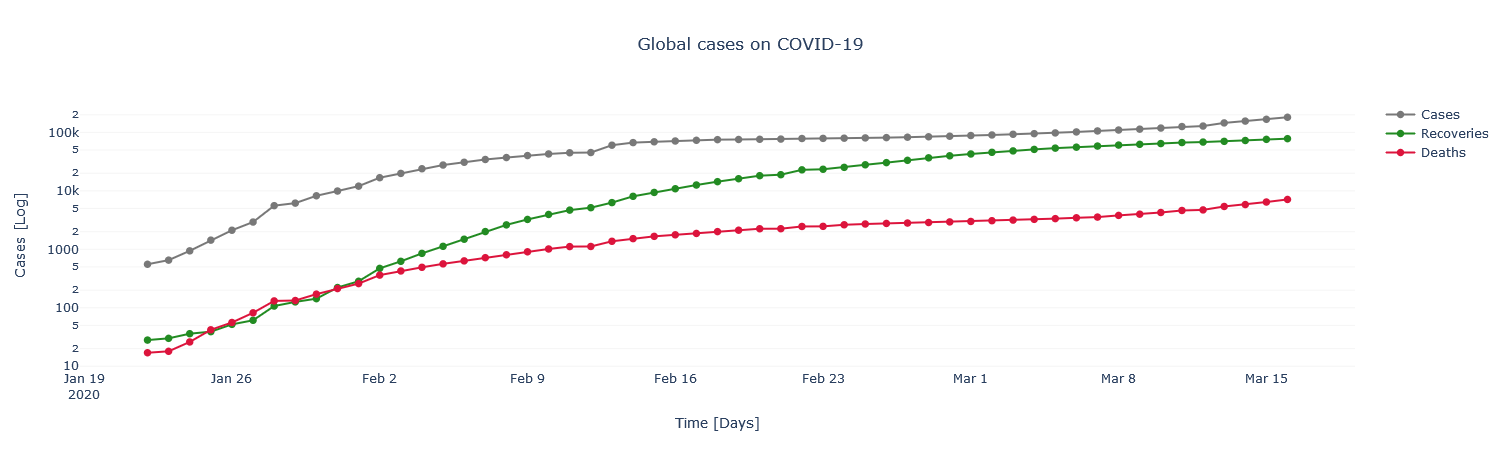

In [112]:
# plot graph
fig = go.Figure()

fig.add_trace(
    go.Scatter(
    mode = 'lines+markers',
    x=ac_series.index, 
    y=ac_series, 
    name='Cases', 
    marker=dict(color='rgb(120,120,120)', 
                line=dict(color='rgb(120,120,120)', width=1.5))
    ))

# Include reconvery from disease
fig.add_trace(
    go.Scatter(
        mode = 'lines+markers',
        x=ac_series.index,
        y=all_recov,
        name='Recoveries',        
        marker=dict(color='forestgreen',
                    line=dict(color='forestgreen', width=1.5))        
    ))

# Include deaths from disease
fig.add_trace(
    go.Scatter(
        mode = 'lines+markers',
        x=ac_series.index,
        y=all_death,
        name='Deaths',        
        marker=dict(color='crimson',
                    line=dict(color='crimson', width=1.5))        
    ))

fig.update_layout(
    title = 'Global cases on COVID-19',
    title_x=0.5,
    xaxis_title = 'Time [Days]',
    yaxis_title = 'Cases [Log]',
    plot_bgcolor='white', yaxis_type="log"
)

# change y axis grid options
fig.update_yaxes(
    showgrid=True, gridwidth=.3, gridcolor='gainsboro'
    # zeroline=True, zerolinewidth=.3, zerolinecolor=axis_color
)

fig.show()

## Study cases in France

Check the current status of diagnosed cases 

In [113]:
# interesting data exist from Feb 23, 2020 then a filter is applied at the plot code area
start_date = '2020-2-23'
mask = df_c.Date > start_date

In [114]:
# Extract all info for mainland France (exclude all other islands)
c_study = 'France - France'
#c_study = 'Mexico'
#c_study = 'Germany'
#c_study = 'Italy'

for cidx, c in enumerate(df_c.columns):
    # check if mainland
    if c == c_study:
        fr_cases = np.array(df_c[c], dtype=int)
        ts_fr = pd.Series(data=fr_cases, index=df_c.Date)
        fr_death = np.array(df_d[c], dtype=int)
        fr_recov = np.array(df_r[c], dtype=int)

### Other countries analysis & figures

In [115]:
# check for data only in main land France (country & region with France as name)
c_study = 'Italy'
for cidx, c in enumerate(df_c.columns):
    # check for country match province 
    if c==c_study:
        data_italy = np.array(df_c[c])

In [116]:
# Create time series for Italy
ts_it = pd.Series(data_italy, index=df_c.Date)

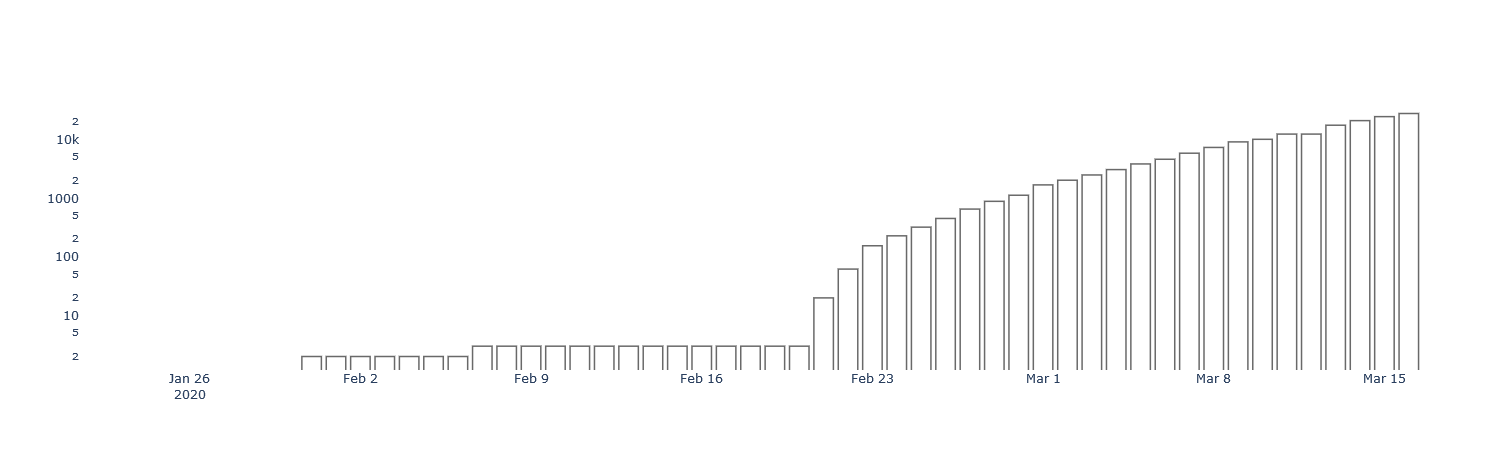

In [117]:
# Display data from Italy
fig = go.Figure([go.Bar(
    x=ts_it.index, 
    y=ts_it,
    marker=dict(color='white', 
                line=dict(color='DimGray', width=1.5))
    )])
fig.update_layout(plot_bgcolor='white', yaxis_type="log")
fig.show()

## France vs Italy

Check the evolution of coronavirus in both countries

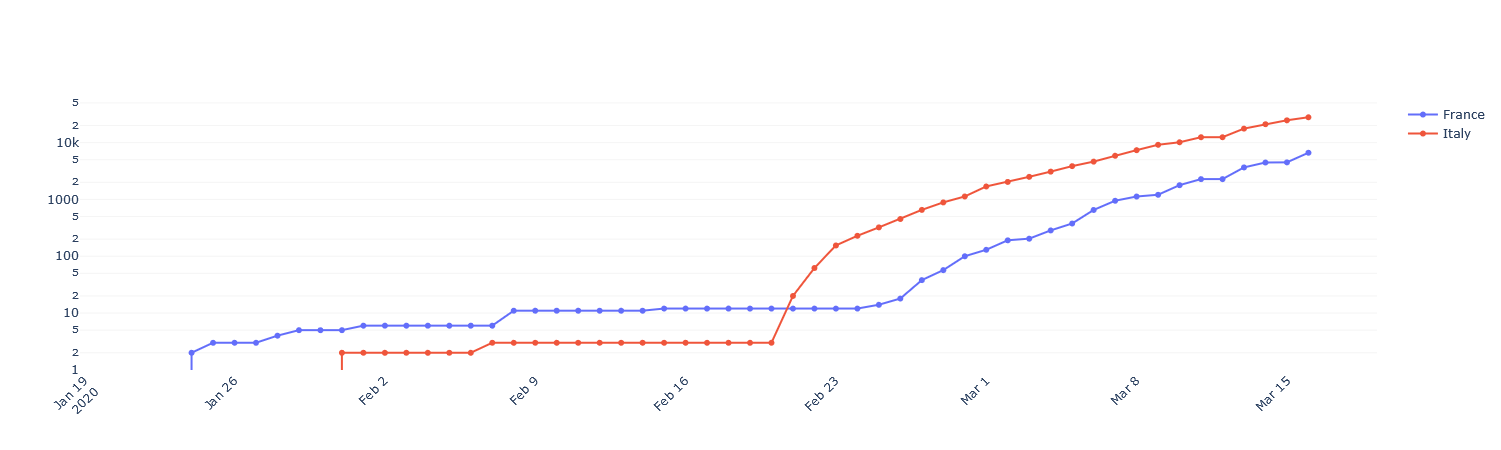

In [118]:
# Compare confirmed cases in France and Italy
fig = go.Figure(data=[
    go.Scatter(name='France', x=ts_fr.index, y=ts_fr, mode='lines+markers'),
    go.Scatter(name='Italy', x=ts_it.index, y=ts_it, mode='lines+markers')
])
# change y axis grid options
fig.update_yaxes(
    showgrid=True, gridwidth=.3, gridcolor='gainsboro'
    # zeroline=True, zerolinewidth=.3, zerolinecolor=axis_color
)
# change x axis grid options
fig.update_layout(
    xaxis = dict(
        #tickformat = '%d/%m',
        tickmode = 'auto',
        tickangle = -45,
        #tickvals = df_c.Date

    ))
                     
# change background color, yaxis type and horizontal bar selector
fig.update_layout(plot_bgcolor='white', yaxis_type="log", xaxis_rangeslider_visible=False)

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')

fig.show()

#### fast check of other country

In [119]:
# list of all countries within df
countries = df_c_raw['Country/Region'].unique()
print(countries)

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

In [122]:
#check turkish report 
c_study='Mexico'

c_data = np.array(df_c[c_study], dtype=int)
r_data = np.array(df_r[c_study], dtype=int)
d_data = np.array(df_d[c_study], dtype=int)

Balance from Mexico


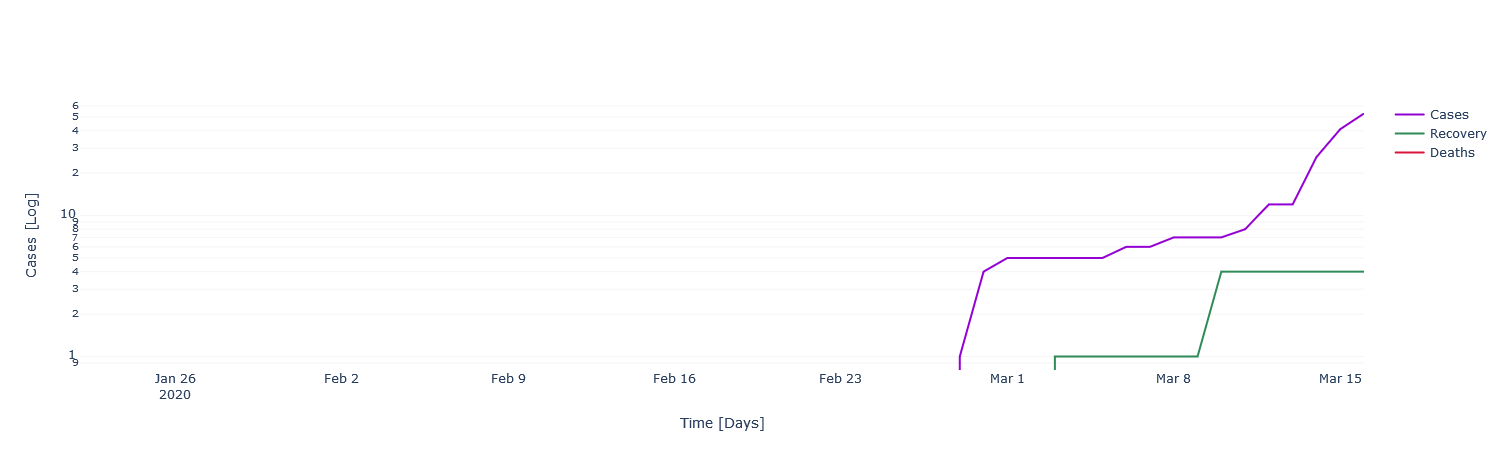

In [123]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        mode='lines',
        x=df_c.Date, y=c_data,
        name='Cases',
        marker = dict(color='DarkViolet')
))
fig.add_trace(
    go.Scatter(
        mode='lines',
        x=df_c.Date, y=r_data,
        name='Recovery',
        marker = dict(color='SeaGreen')
))
fig.add_trace(
    go.Scatter(
        mode='lines',
        x=df_c.Date, y=d_data,
        name='Deaths',
        marker = dict(color='crimson')
))
# change background color, yaxis type and horizontal bar selector
fig.update_layout(
    xaxis_title = 'Time [Days]',
    yaxis_title = 'Cases [Log]',
    title = print('Balance from %s' %(c_study)),
    plot_bgcolor='white', yaxis_type="log")

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='gainsboro')
# change y axis grid options
fig.update_yaxes(showgrid=True, gridwidth=.3, gridcolor='gainsboro')

### Compare countries covid-19 disease development

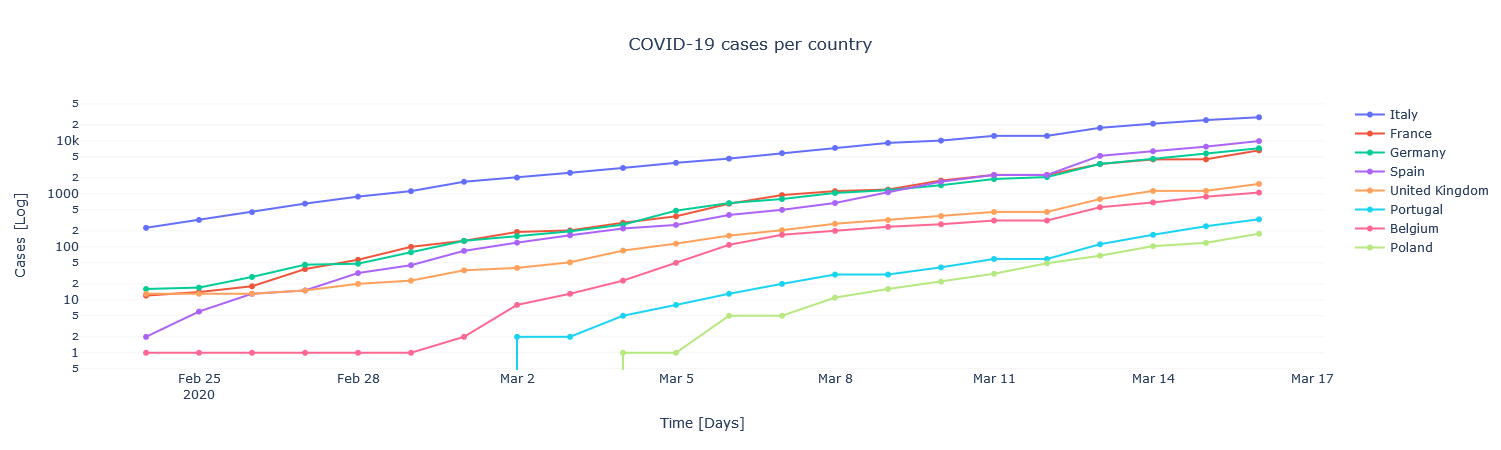

In [133]:
# List with countries to compare
list_c = ['Italy', 'France', 'Germany', 'Spain', 'United Kingdom', 'Portugal', 'Belgium', 'Poland']

fig = go.Figure()

for c in list_c:
    if c == 'France':
        data_c = np.array(df_c['France - France'], dtype=int)
    elif c == 'United Kingdom':
        data_c = np.array(df_c['United Kingdom - United Kingdom'], dtype=int)
    else:
        data_c = np.array(df_c[c], dtype=int)

    fig.add_trace(
        go.Scatter(
            mode = 'lines+markers',
            x = df_c.Date[mask],
            y = data_c[mask], 
            name = c
        ))
    
# change background color, yaxis type and horizontal bar selector
fig.update_layout(
    xaxis_title = 'Time [Days]',
    yaxis_title = 'Cases [Log]',
    title = 'COVID-19 cases per country',
    title_x = 0.5,
    plot_bgcolor='white', yaxis_type="log"
)

# change y axis grid options
fig.update_yaxes(showgrid=True, gridwidth=.3, gridcolor='gainsboro')

Data compare to the number of inhabitants per country. Population data available at https://data.worldbank.org/

In [134]:
# get total population from online repository (Out-dated)
# glob_pop_url = 'https://query.data.world/s/4ntitiskmvbauwvd4hb5teu4sjgw4a'
# df_gp = pd.read_csv(glob_pop_url, skiprows=4)

# get total population from local repository (originally from data.worldbank.org, last visited 16 March 2020)
df_gp_raw = pd.read_csv('local_data/world_population/API_SP.POP.TOTL_DS2_en_csv_v2_866861.csv', skiprows=4)

In [135]:
# Mark year for analysis
year_analysis = pd.datetime(2018,1,1)

# Prepare dataframe
col_names = df_gp_raw.columns
date_data = pd.to_datetime(df_gp_raw.columns[4:-2])
df_gp_raw['Country Name']
# Get columns header from country columns
col_headers = pd.Series(data=df_gp_raw['Country Name'], dtype='str')

# Build new dataframe exclude 2019 and any other column with text
df_gp = pd.DataFrame(data=date_data, columns=['Date'])
for cidx, c in enumerate(col_headers):
    data_tmp = np.array(df_gp_raw.iloc[cidx][4:-2], dtype='float')
    df_gp[c] = data_tmp

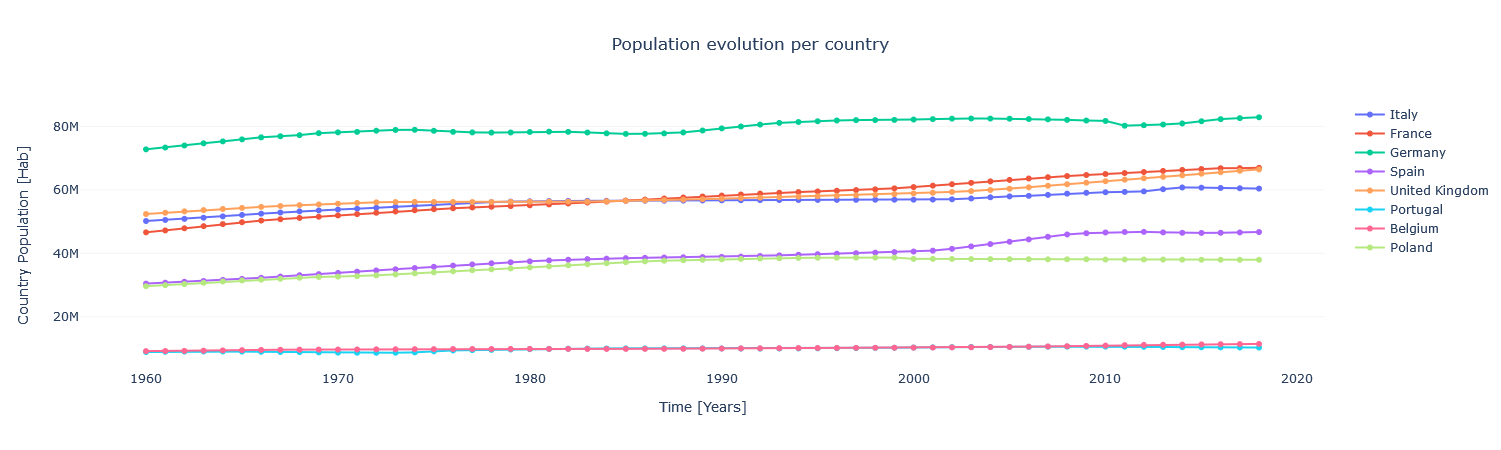

In [138]:
# Display population grow for countries previously check
fig = go.Figure()

for c in list_c: 
    data_plot = np.array(df_gp[c])
    fig.add_trace(go.Scatter(
        mode = 'lines+markers',
        x = df_gp.Date,
        y = data_plot,
        name = c
    ))
    
# change background color, yaxis type and horizontal bar selector
fig.update_layout(
    xaxis_title = 'Time [Years]',
    yaxis_title = 'Country Population [Hab]',
    title = 'Population evolution per country',
    title_x = 0.5,
    plot_bgcolor='white'
)

# change y axis grid options
fig.update_yaxes(showgrid=True, gridwidth=.3, gridcolor='gainsboro')

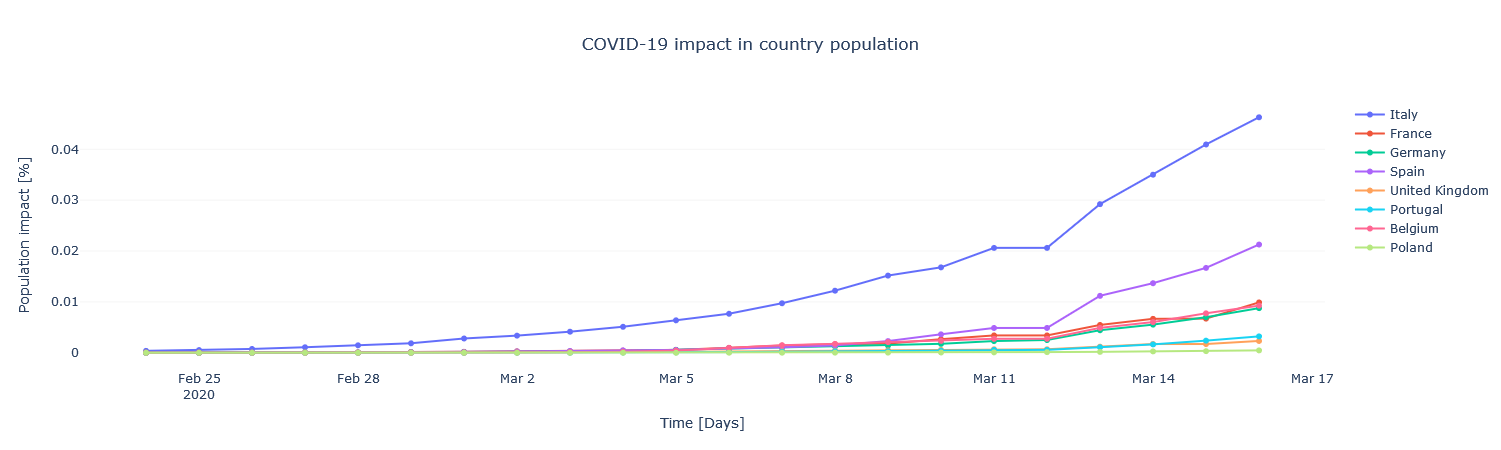

In [137]:
# Calculate the impact of covid-19 over the total population per country
fig = go.Figure()

for c in list_c:
    # check country population for year_analysis
    pop_year = np.array(df_gp[c][df_gp.Date == year_analysis], dtype=int)
    if c == 'France':
        data_c = np.array(df_c['France - France'], dtype=int)
    elif c == 'United Kingdom':
        data_c = np.array(df_c['United Kingdom - United Kingdom'], dtype=int)
    else:
        data_c = np.array(df_c[c], dtype=int)

    fig.add_trace(
        go.Scatter(
            mode = 'lines+markers',
            x = df_c.Date[mask],
            y = data_c[mask] / pop_year * 100, 
            name = c
        ))
    
# change background color, yaxis type and horizontal bar selector
fig.update_layout(
    xaxis_title = 'Time [Days]',
    yaxis_title = 'Population impact [%]',
    title = 'COVID-19 impact in country population',
    title_x = 0.5,
    plot_bgcolor='white'
)

# change y axis grid options
fig.update_yaxes(showgrid=True, gridwidth=.3, gridcolor='gainsboro')